# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [28]:
# Notebooks specific imports
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display

from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.optimize import root_scalar

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import (
    Circle,
    RegularPolygon,
    FancyArrowPatch,
    ArrowStyle,
    Rectangle,
)
from matplotlib.ticker import (
    MultipleLocator,
    FormatStrFormatter,
    AutoMinorLocator,
    NullFormatter,
)
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path("/home/alamson/DATA/Chromatin/")
mnt_path = Path.home() / "projects/DATA/Chromatin/"
ceph_path = Path.home() / "ceph/DATA/Chromatin/"

In [2]:
# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min = 40

### Style settings

In [4]:
def plot_confidence_int(
    ax, time_arr, mean, std_dev, num_runs=12, color="b", ci=0.95, label="Mean", alpha=1.
):
    degrees_freedom = num_runs 
    confidence_interval = (
        stats.t.ppf((1 + ci) / 2.0, degrees_freedom) * std_dev / np.sqrt(num_runs)
    )

    _ = ax.plot(time_arr, mean, label=label, color=color, alpha=alpha)
    _ = ax.fill_between(
        time_arr,
        mean - confidence_interval,
        mean + confidence_interval,
        color=color,
        alpha=0.1,
    )

7201
7201
7201
7201


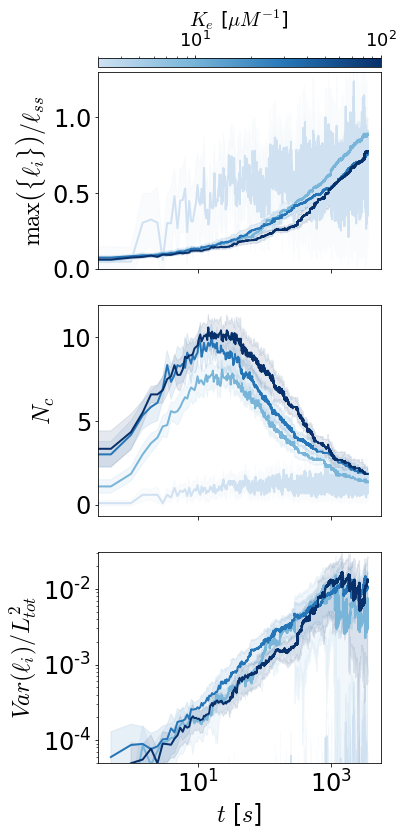

In [65]:
labels_to_graph_dict = {
    # r"$K_e = 1~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke1/",
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
}
cmap = plt.cm.Blues
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', colors)

fig, axarr = plt.subplots(3,1, figsize=(6, 12), sharex=True)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        ss_mean = h5_data[-time_arr.size // 5 :, 0].mean()
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot total condensed fraction

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr[0].set_xscale("log")

    _ = axarr[0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / \ell_{ss}$")

    _ = axarr[1].set_ylabel("$N_c$")
    
    _ = axarr[2].set_ylabel("$Var(\ell_i)/ L_{tot}^2$")
    _ = axarr[2].set_ylim(.00005)
    _ = axarr[0].set_ylim(.0, 1.3)
    _ = axarr[2].set_yscale("log")
    _ = axarr[2].set_xlabel("$t$ [$s$]")

norm = mcolors.LogNorm(vmin=3, vmax=100)
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$K_e$ [$\mu M^{-1}$]', fontsize=20)
cbar.ax.tick_params(labelsize=18)
# cbar.ax.set_position([0.15, 0.95, 0.7, 0.02])
# cbar.set_ticks(np.arange(n_shades))
# cbar.set_ticklabels(list(labels_to_graph_dict.keys()))


fig.tight_layout()
fig.savefig("Figure2/fig3_cond_dyn_ke_lss.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn_ke_lss.png", dpi=300, bbox_inches="tight")



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


7201
7201
7201
7201


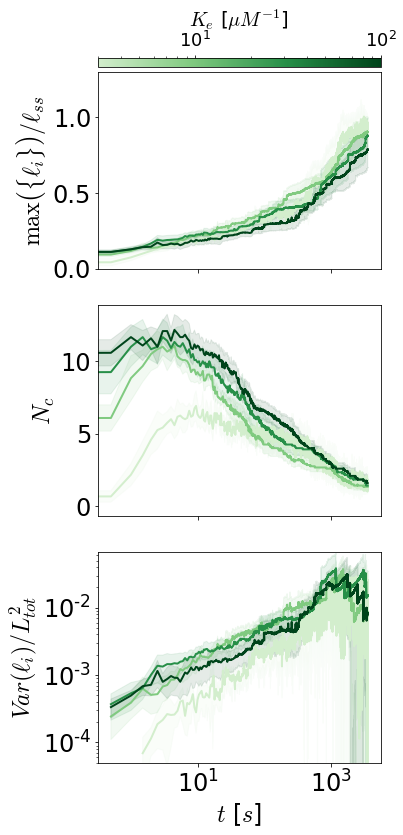

In [58]:
labels_to_graph_dict = {
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin3.0um_Ke1/",
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin3.0um_Ke3/",
    r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin3.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin3.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin3.0um_Ke100",
}
cmap = plt.cm.Greens
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', colors)

fig, axarr = plt.subplots(3,1, figsize=(6, 12), sharex=True)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        ss_mean = h5_data[-time_arr.size // 5 :, 0].mean()
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot total condensed fraction

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr[0].set_xscale("log")

    _ = axarr[0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / \ell_{ss}$")

    _ = axarr[1].set_ylabel("$N_c$")
    
    _ = axarr[2].set_ylabel("$Var(\ell_i)/ L_{tot}^2$")
    _ = axarr[2].set_ylim(.00005)
    _ = axarr[0].set_ylim(.0, 1.3)
    _ = axarr[2].set_yscale("log")
    _ = axarr[2].set_xlabel("$t$ [$s$]")

norm = mcolors.LogNorm(vmin=3, vmax=100)
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=18)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$K_e$ [$\mu M^{-1}$]', fontsize=20)
# cbar.ax.set_position([0.15, 0.95, 0.7, 0.02])
# cbar.set_ticks(np.arange(n_shades))
# cbar.set_ticklabels(list(labels_to_graph_dict.keys()))


fig.tight_layout()
# fig.savefig("Figure2/fig3_cond_dyn.png", dpi=300, bbox_inches="tight")
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn.png", dpi=300, bbox_inches="tight")



7201
7201
7201
7201
7201


/tmp/ipykernel_223133/3747179189.py:41: RuntimeWarning: divide by zero encountered in true_divide
  mean / ss_mean,
/tmp/ipykernel_223133/3747179189.py:41: RuntimeWarning: invalid value encountered in true_divide
  mean / ss_mean,
/tmp/ipykernel_223133/3747179189.py:42: RuntimeWarning: divide by zero encountered in true_divide
  std_dev / ss_mean,
/tmp/ipykernel_223133/3747179189.py:42: RuntimeWarning: invalid value encountered in true_divide
  std_dev / ss_mean,
/tmp/ipykernel_223133/97324806.py:12: RuntimeWarning: invalid value encountered in subtract
  mean - confidence_interval,


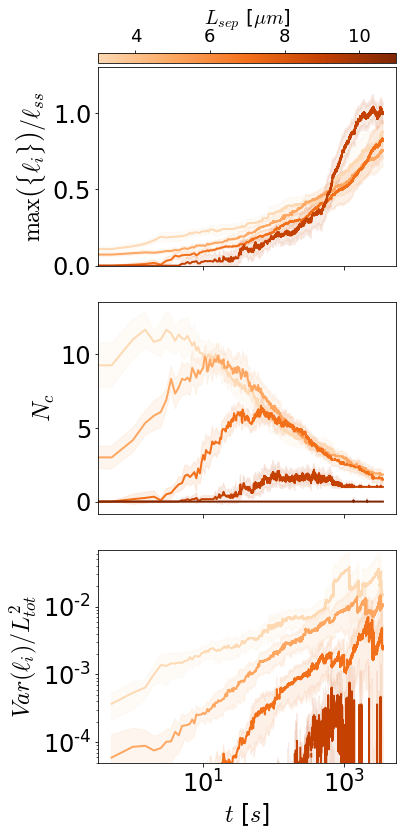

In [66]:
labels_to_graph_dict = {
    # r"$K_e = 1~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke1/",
    # r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    # r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke30/",
    # r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke30",
}
cmap = plt.cm.Oranges
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', colors)

fig, axarr = plt.subplots(3,1, figsize=(6, 12), sharex=True)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        ss_mean = h5_data[-time_arr.size // 5 :, 0].mean()
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot total condensed fraction

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr[0].set_xscale("log")

    _ = axarr[0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / \ell_{ss}$")

    _ = axarr[1].set_ylabel("$N_c$")
    
    _ = axarr[2].set_ylabel("$Var(\ell_i)/ L_{tot}^2$")
    _ = axarr[2].set_ylim(.00005)
    _ = axarr[0].set_ylim(.0, 1.3)
    _ = axarr[2].set_yscale("log")
    _ = axarr[2].set_xlabel("$t$ [$s$]")

# norm = mcolors.LogNorm(vmin=3, vmax=300)
norm = mcolors.Normalize(vmin=3, vmax=11)
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04, label='$K_e$ [$\mu M^{-1}$]', )
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$L_{sep}$ [$\mu m$]', fontsize=20)
# cbar.ax.set_position([0.15, 0.95, 0.7, 0.02])
# cbar.set_ticks(np.arange(n_shades))
# cbar.set_ticklabels(list(labels_to_graph_dict.keys()))


fig.tight_layout()
fig.savefig("Figure2/fig3_cond_dyn_Lsep_lss.png", dpi=300, bbox_inches="tight")
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn_Lsep_lss.png", dpi=300, bbox_inches="tight")



7201
7201
7201
7201


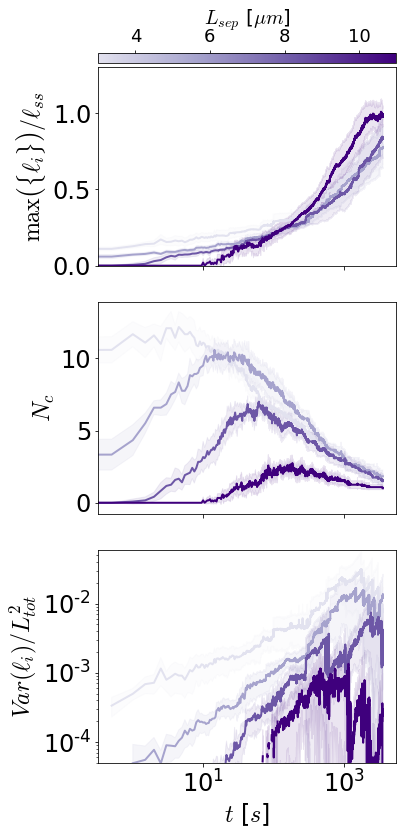

In [67]:
labels_to_graph_dict = {
    # r"$K_e = 1~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke1/",
    # r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    # r"$K_e = 10~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke10/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 7~\mu {\rm m}$": "Pin7.0um_Ke100/",
    # r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke100",
    # r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 11~\mu {\rm m}$": "Pin11.0um_Ke100",
}
cmap = plt.cm.Purples
n_shades = len(labels_to_graph_dict.keys())
colors = [color for color in cmap(np.linspace(0.2, 1, n_shades))]
new_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', colors)

fig, axarr = plt.subplots(3,1, figsize=(6, 12), sharex=True)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        ss_mean = h5_data[-time_arr.size // 5 :, 0].mean()
        # ss_mean=1600
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot total condensed fraction

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / ss_mean,
            std_dev / ss_mean,
            num_runs,
            color=color,
            label=label,
        )

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr[0].set_xscale("log")

    _ = axarr[0].set_ylabel( r"$\max\left(\{\ell_i\}\right) / \ell_{ss}$")

    _ = axarr[1].set_ylabel("$N_c$")
    
    _ = axarr[2].set_ylabel("$Var(\ell_i)/ L_{tot}^2$")
    _ = axarr[2].set_ylim(.00005)
    _ = axarr[0].set_ylim(.0, 1.3)
    _ = axarr[2].set_yscale("log")
    _ = axarr[2].set_xlabel("$t$ [$s$]")

# norm = mcolors.LogNorm(vmin=3, vmax=300)
norm = mcolors.Normalize(vmin=3, vmax=11)
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

cax0 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)
cbar = fig.colorbar(sm,  cax=cax0, orientation='horizontal', fraction=0.02, pad=0.04, label='$K_e$ [$\mu M^{-1}$]', )
cbar.ax.tick_params(labelsize=18)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.set_label('$L_{sep}$ [$\mu m$]', fontsize=20)
# cbar.ax.set_position([0.15, 0.95, 0.7, 0.02])
# cbar.set_ticks(np.arange(n_shades))
# cbar.set_ticklabels(list(labels_to_graph_dict.keys()))


fig.tight_layout()
# fig.savefig("Figure2/fig3_cond_dyn.png", dpi=300, bbox_inches="tight")
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig3_cond_dyn.png", dpi=300, bbox_inches="tight")



# Old

7201
7201
7201
7201
7201
1440


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


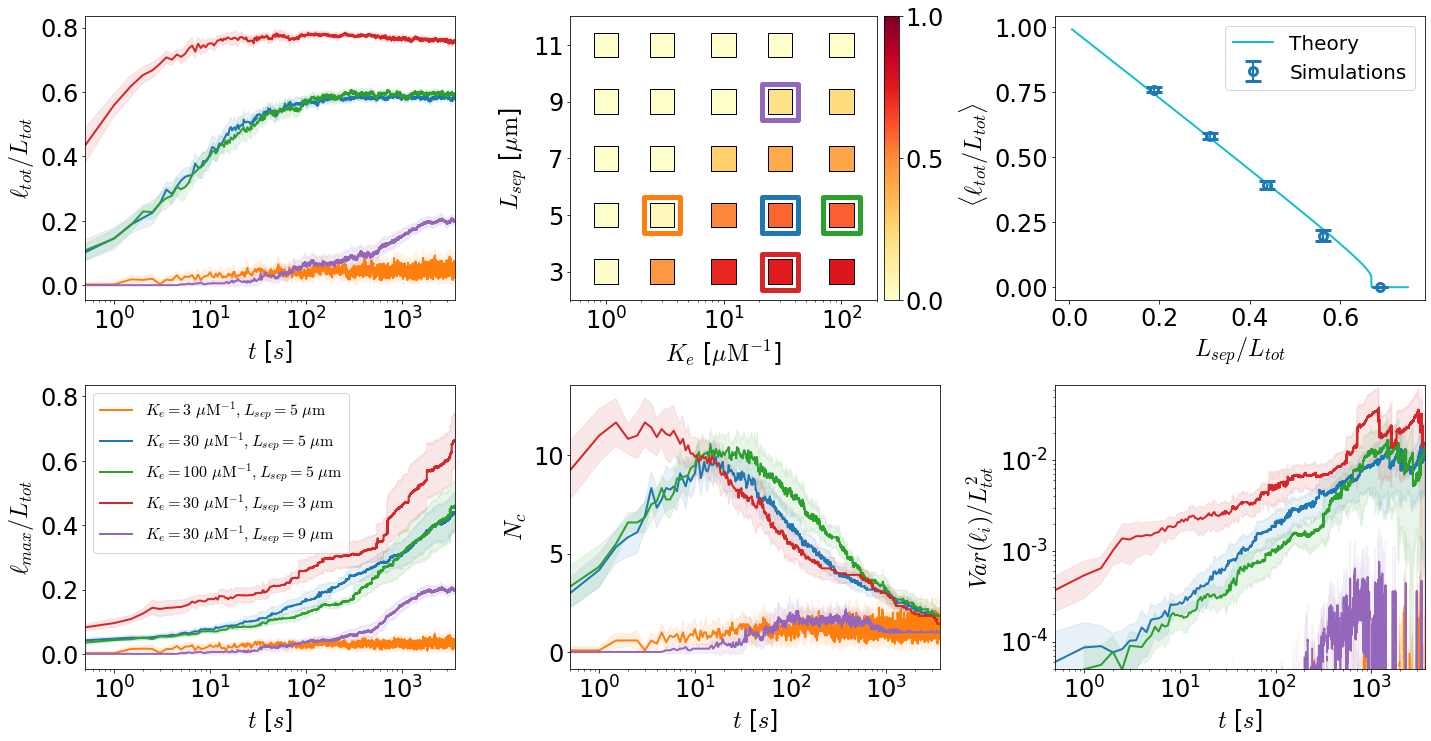

In [ ]:
labels_to_graph_dict = {
    r"$K_e = 3~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke3/",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke30/",
    r"$K_e = 100~\mu {\rm M}^{-1}, L_{sep} = 5~\mu {\rm m}$": "Pin5.0um_Ke100",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$K_e = 30~\mu {\rm M}^{-1}, L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
}
colors = ['C1', 'C0','C2', 'C3', 'C4']

fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2,9)

axarr = []
axarr +=[fig.add_subplot(gs[0,:3] )]
axarr +=[fig.add_subplot(gs[0,3:6])]
axarr +=[fig.add_subplot(gs[0,6:])]
axarr +=[fig.add_subplot(gs[1,:3], sharex=axarr[0], sharey=axarr[0] )]
axarr +=[fig.add_subplot(gs[1,3:6], sharex=axarr[0])]
axarr +=[fig.add_subplot(gs[1,6:], sharex=axarr[0])]
# axarr +=[fig.add_subplot(gs[1,6:], sharex=axarr[0])]

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]

        # Plot total condensed fraction
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            12,
            color=color,
            label=label,
        )

        # Plot chain in largest cluster
        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[3],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            num_runs,
            color=color,
            label=label,
        )

        # Plot number of clusters
        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[4],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

        #Plot variance of cluster size
        mean = h5_data[:min_length, 6]
        std_dev = h5_data[:min_length, 7]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[5],
            time_arr[:min_length],
            mean/(1600**2) ,
            std_dev/(1600**2),
            num_runs,
            color=color,
            label=label,
        )


    _ = axarr[0].set_xscale("log")
    _ = axarr[0].set_ylabel("$\ell_{tot} / L_{tot}$")

    _ = axarr[3].set_ylabel( "$\ell_{max} / L_{tot}$")
    _ = axarr[3].set_ylabel(
        "$\ell_{max} / L_{tot}$"
    )
    
    _ = axarr[5].set_ylabel("$Var(\ell_i)/ L_{tot}^2$")
    _ = axarr[5].set_ylim(.00005)
    _ = axarr[5].set_yscale("log")

    _ = axarr[4].set_ylabel("$N_c$")
    _ = axarr[0].set_xlabel("$t$ [$s$]")
    _ = axarr[3].set_xlabel("$t$ [$s$]")
    _ = axarr[4].set_xlabel("$t$ [$s$]")
    _ = axarr[5].set_xlabel("$t$ [$s$]")
_ = axarr[0].set_xlim(5e-1, 3600)

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 8))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[-time_arr.size // 5 :, 0].mean(),
                h5_data[-time_arr.size // 5 :, 1].mean(),
                h5_data[-time_arr.size // 5 :, 2].mean(),
                h5_data[-time_arr.size // 5 :, 3].mean(),
                h5_data[-time_arr.size // 5 :, 4].mean(),
                h5_data[-time_arr.size // 5 :, 5].mean(),
            ]
print(time_arr.size // 5)

## Draw boxes around the selected points

# Define the color conditions
conditions = [
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 3),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 100),
    (data_arr[:,0] == 3.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 9.0) & (data_arr[:,1] == 30),
]

# Define the color for each condition
colors = ['C1', 'C0','C2', 'C3', 'C4']

# Use np.select to assign colors to the conditions
color_array = np.select(conditions, colors, default= 'none')

# Graph outlining boxes
_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    facecolors="none",
    # c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=1300,
    marker="s",
    edgecolors=color_array,
    linewidths=5,
)

## Condensed fraction graph
_ = axarr[1].set_xscale("log")
_ = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=600,
    marker="s",
    edgecolors='k',
    linewidths=1,
)
cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="YlOrRd"),
    ax=axarr[1],
    pad=0.02,
    # label=r" $\langle \ell_{tot}/L_{tot} \rangle$",
    # label="Mean condensed \n chain fraction" + r" $\langle \ell_{tot}/L_{tot} \rangle$",
)
cb1.set_ticks([0, 0.5, 1])


_ = axarr[1].set_xlim(0.5, 200)
_ = axarr[1].set_ylim(2, 12)

_ = axarr[1].set_ylabel(r"$L_{sep}$ [$\mu {\rm m}$]")
_ = axarr[1].set_xlabel(r"$K_e$ [$\mu {\rm M}^{-1}$]")

_ = axarr[1].set_xticks([1,10,100])
_ = axarr[1].set_yticks([3,5,7,9,11])


## Comparison with theory from equilibrium model

mu = 4.1  # Free energy per volume pN/um^2
alpha = 0.05  # Condensate packing factor um^2
gamma = 0.15  # Surface tension pN/um
kappa = 0.0822  # Filament flexibility pN
Ltot = 16.0  # Total length of the polymer um

beta = 1.0 / 0.0041
# fig, axarr = plt.subplots(1, 1, figsize=(5, 5))


# Get theoretical results
lsep_arr = np.linspace(0.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size)
for i, lsep in enumerate(lsep_arr):
    bound = 0.1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += 0.5
    if bound > Ltot - (lsep * 1.0000001):
        ld_max_prob[i] = 0.0
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(
        free_energy_deriv,
        method="brentq",
        bracket=[bound, Ltot - (lsep * 1.0000001)],
        args=(Ltot, lsep, mu, alpha, gamma, kappa),
    )
    ld_max_prob[i] = result.root
_ = axarr[2].plot(lsep_arr / Ltot, ld_max_prob / Ltot, label="Theory", color="C9")
_ = axarr[2].set_xlabel(r"$L_{sep}/L_{tot}$")
_ = axarr[2].set_ylabel(r" $\langle \ell_{tot}/L_{tot} \rangle$"),

with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs["Ke"], h5_data.attrs["pin_dist"]
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size // 2 :, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size // 2 :, 1].mean()]

    _ = axarr[2].errorbar(
        np.array(pin_dist_arr) / 16.0,
        np.array(beads_num_arr) / 1600.0,
        yerr=np.array(beads_std_arr) / 1600.0,
        fmt="o",
        markeredgewidth=3,
        markeredgecolor="C0",
        markersize=8,
        markerfacecolor="none",
        capsize=8,
        label="Simulations",
    )

_ = axarr[2].legend()
_ = axarr[3].legend(fontsize=16)
# _ = axarr[4].legend(loc='center left', bbox_to_anchor=(1.05, .5))
# fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.5)
fig.subplots_adjust(hspace=0.3, wspace=2.5)
# fig.tight_layout()

fig.savefig("Figure2/fig2_combined.png", dpi=300, bbox_inches="tight")
